In [1]:
import numpy as np
import scipy.linalg
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cycler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
monochrome = (cycler('color', ['k']) * cycler('lw', [1.1, 3.0]) * cycler('linestyle', ['-', '--', ':', '-.']))

In [3]:
# %matplotlib notebook

In [4]:
def MakeStationary(ts):
    new_ts = []
    for i in range(1, len(ts)):
        new_ts.append(ts[i] - ts[i - 1])
    return np.array(new_ts)

In [5]:
def HankelMatrix(X, L):
    N = X.shape[0]
    return scipy.linalg.hankel(X[ : N - L + 1], X[N - L : N])

In [6]:
def MeanTrajByPeriod(tr, T):
    tr_mean = np.zeros((T + 1, tr.shape[1]))
    for t in range(T):
        tr_mean[t] = np.mean(tr[t::T], axis=0)

    tr_mean[-1] = np.copy(tr_mean[0])
    return tr_mean

In [7]:
def Svd(H, verbose=False):
    U, s, VT = np.linalg.svd(H)
    if verbose:
        print(s[:5])
    return U, s, VT

def Projection(U, s, V):
    print(U.shape, s.shape, V.shape)
    L = V.shape[1]
    S = np.zeros((U.shape[0], L))
    S[:L, :L] = np.diag(s)
    
    return U.dot(S)


def CCM(H):
    svd_data = Svd(H, verbose=False)
    Pr = Projection(*svd_data)
    return Pr

### Energy consumption

In [36]:
data = pd.read_csv('data/EnergyConsumption.csv').iloc[:, 3:]
day_len_data = pd.read_csv('day_len.csv').iloc[:, 3]

In [37]:
x = np.array(data["ConsumprionMWtH"])
mean = x.mean()
std = x.std()
x = MakeStationary((x - mean) / std)

In [38]:
z = []

for i in range(day_len_data.shape[0]):
    length = day_len_data.iloc[i]
    
    for j in range(24):
        z.append(length)
        
z = np.array(z)

mean = z.mean()
std = z.std()

z = (z - mean) / std

In [39]:
scaler = StandardScaler()
scaler.fit(data)
scaled_data = scaler.transform(data)

x = np.array(scaled_data[:, 0])
y = np.array(scaled_data[:, 1])

In [40]:
def crosscorr(x, y, lag=0):
    return x.corr(y.shift(lag))

cross_corr_list = []

for i in range(0, len(y) - 100):
    cross_corr_list.append(crosscorr(pd.Series(y), pd.Series(z), i))

shift = np.argmax(abs(np.array(cross_corr_list)))

In [41]:
y_new = []

for i in range(shift, len(y)):
    y_new.append(y[i] - z[i - shift])
    
y_new = np.array(y_new)
y = y_new

In [42]:
x = np.array(MakeStationary(x))
y = np.array(MakeStationary(y))

In [43]:
pca = PCA(n_components=3)

Hx = HankelMatrix(x[6000:], L=200)
x_3d = pca.fit_transform(Hx)

Hy = HankelMatrix(y[6000:], L=200)
y_3d = pca.fit_transform(Hy)

In [44]:
T = 24
x_mean = MeanTrajByPeriod(x_3d[:501], T)

In [45]:
# %matplotlib notebook

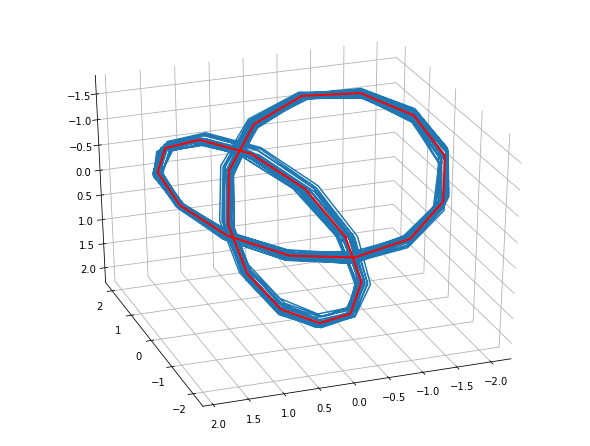

In [46]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.plot3D(x_3d[:500, 2], x_3d[:500, 1], x_3d[:500, 0])
ax.plot3D(x_mean[:, 2], x_mean[:, 1], x_mean[:, 0], c='r', linewidth=2)

# ax.set_title("Потребление электроэнергии", size=16)

ax.set_facecolor((1.0, 1.0, 1.0))
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))


# plt.savefig('pictures/energy_cons_3d_traj_with_mean_no_title.eps', bbox_inches='tight')

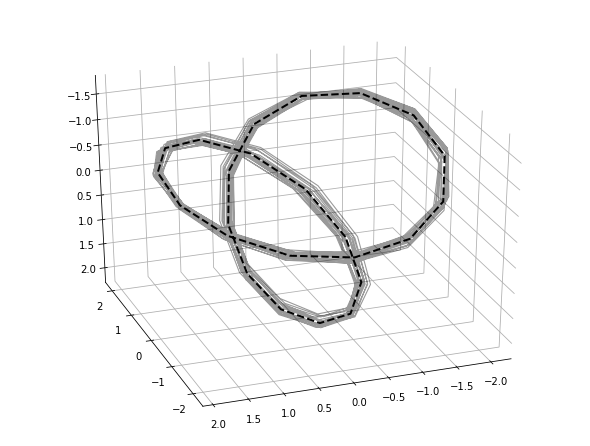

In [47]:
init_colors = plt.rcParams['axes.prop_cycle']
plt.rcParams['axes.prop_cycle'] = monochrome

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.plot3D(x_3d[:500, 2], x_3d[:500, 1], x_3d[:500, 0], alpha=0.4)
ax.plot3D(x_mean[:, 2], x_mean[:, 1], x_mean[:, 0], linewidth=2, linestyle='--')

# ax.set_title("Потребление электроэнергии", size=16)

ax.set_facecolor((1.0, 1.0, 1.0))
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

plt.rcParams['axes.prop_cycle'] = init_colors

# plt.savefig('pictures/energy_cons_3d_traj_with_mean_no_title_monochrome.jpg', bbox_inches='tight')

### Accelerometer walking

In [48]:
mat_wlk = scipy.io.loadmat('data/acc_wlk.mat')['sensor_readings']

scaler = StandardScaler()
scaled_data = scaler.fit_transform(np.hstack((mat_wlk[:, 0][:, np.newaxis], mat_wlk[:, 3][:, np.newaxis])))

x = scaled_data[:, 0]
y = scaled_data[:, 1]

Hx = HankelMatrix(x, L=200)
Hy = HankelMatrix(y, L=200)

pca = PCA(n_components=3)
x_3d = pca.fit_transform(Hx)
y_3d = pca.fit_transform(Hy)

In [49]:
x_3d.shape

(2201, 3)

In [50]:
x_mean = MeanTrajByPeriod(x_3d[:500], 46)

In [51]:
# %matplotlib notebook

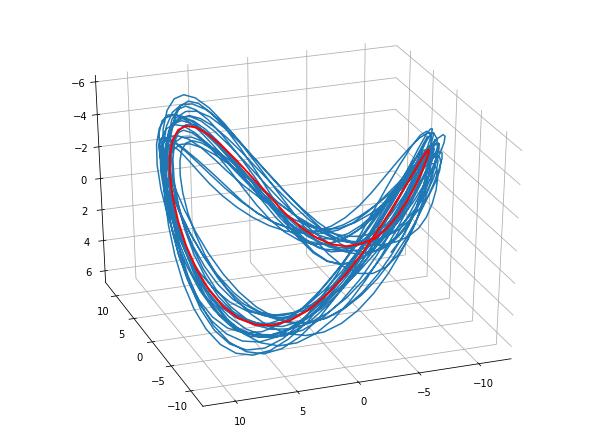

In [52]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.plot3D(x_3d[:1000, 1], x_3d[:1000, 0], x_3d[:1000, 2])
ax.plot3D(x_mean[:, 1], x_mean[:, 0], x_mean[:, 2], c='r', linewidth=2)

# ax.set_title("Акселерометр, ходьба", size=16)

ax.set_facecolor((1.0, 1.0, 1.0))
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# plt.savefig('pictures/accelerometer_3d_wlk_traj_with_mean_no_title.eps', bbox_inches='tight')

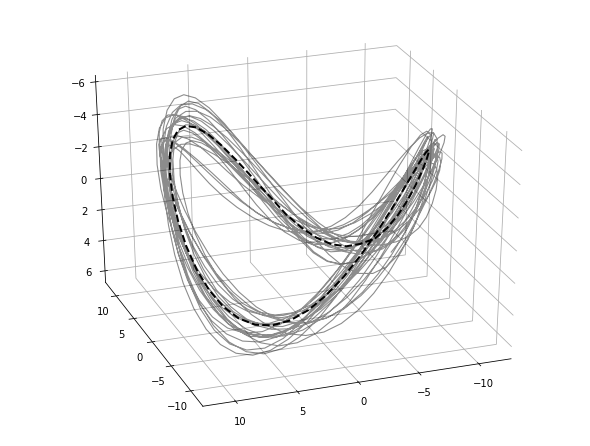

In [53]:
init_colors = plt.rcParams['axes.prop_cycle']
plt.rcParams['axes.prop_cycle'] = monochrome

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
# ax.scatter(x_3d[:, 0], x_3d[:, 1], x_3d[:, 2], cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.plot3D(x_3d[:1000, 1], x_3d[:1000, 0], x_3d[:1000, 2], alpha=0.45)
ax.plot3D(x_mean[:, 1], x_mean[:, 0], x_mean[:, 2], linewidth=2, linestyle='--')

# ax.set_title("Акселерометр, ходьба", size=16)

ax.set_facecolor((1.0, 1.0, 1.0))
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

plt.rcParams['axes.prop_cycle'] = init_colors

# plt.savefig('pictures/accelerometer_3d_wlk_traj_with_mean_no_title_monochrome.jpg', bbox_inches='tight')

### Accelerometer running

In [54]:
mat_wlk = scipy.io.loadmat('data/acc_run.mat')['sensor_readings']

scaler = StandardScaler()
scaled_data = scaler.fit_transform(np.hstack((mat_wlk[:, 0][:, np.newaxis], mat_wlk[:, 3][:, np.newaxis])))

x = scaled_data[:, 0]
y = scaled_data[:, 1]

Hx = HankelMatrix(x, L=200)
Hy = HankelMatrix(y, L=200)

pca = PCA(n_components=3)
x_3d = pca.fit_transform(Hx)
y_3d = pca.fit_transform(Hy)

In [55]:
# %matplotlib notebook

In [56]:
x_mean = MeanTrajByPeriod(x_3d, 123)

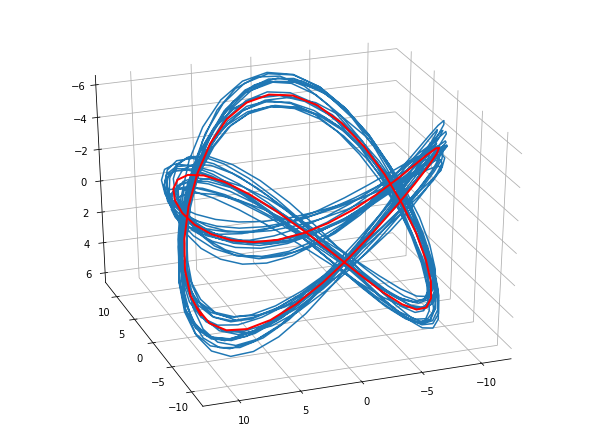

In [57]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
# ax.scatter(x_3d[:, 0], x_3d[:, 1], x_3d[:, 2], cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.plot3D(x_3d[:1000, 0], x_3d[:1000, 1], x_3d[:1000, 2], label='Trajectory')
ax.plot3D(x_mean[:63, 0], x_mean[:63, 1], x_mean[:63, 2], c='r', linewidth=2, label='Center')

# ax.set_title("Акселерометр, бег", size=16)

ax.set_facecolor((1.0, 1.0, 1.0))
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# plt.savefig('pictures/accelerometer_3d_run_traj_with_mean_no_title.eps', bbox_inches='tight')

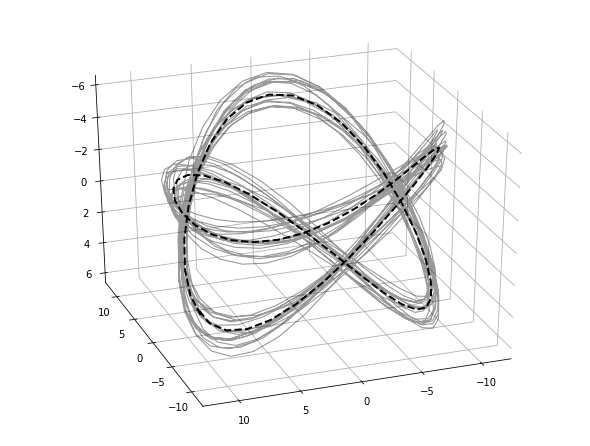

In [58]:
init_colors = plt.rcParams['axes.prop_cycle']
plt.rcParams['axes.prop_cycle'] = monochrome

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
# ax.scatter(x_3d[:, 0], x_3d[:, 1], x_3d[:, 2], cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.plot3D(x_3d[:1000, 0], x_3d[:1000, 1], x_3d[:1000, 2], label='Trajectory', alpha=0.4)
ax.plot3D(x_mean[:63, 0], x_mean[:63, 1], x_mean[:63, 2], label='Center', linewidth=2, linestyle='--')

# ax.set_title("Акселерометр, бег", size=16)

ax.set_facecolor((1.0, 1.0, 1.0))
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

plt.rcParams['axes.prop_cycle'] = init_colors

# plt.savefig('pictures/accelerometer_3d_run_traj_with_mean_no_title_monochrome.jpg', bbox_inches='tight')